## Brain Tumor Classification Without Data Augmentation 

### Import Libraries

In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import tensorflow as tf

RANDOM_SEED = 123

### Create Directory for Train, Test and Validation Dataset

In [2]:
!apt-get install tree
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (91.7 kB/s)
Selecting previously unselected package tree.
(Reading database ... 124015 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
.
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

10 directories


In [3]:
# connect to drive  if running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Split Data in Train, Test and Validation Set




In [4]:
IMAGE_PATH = '/content/drive/MyDrive/FMI/dataset/archive/brain_tumor_dataset/'

for CLASS_ in os.listdir(IMAGE_PATH):

    if not CLASS_.startswith('.'):
        IMG_NUM = len(os.listdir(IMAGE_PATH + CLASS_))

        for (n, FILE_NAME) in enumerate(os.listdir(IMAGE_PATH + CLASS_)):
            image = IMAGE_PATH + CLASS_ + '/' + FILE_NAME
            if n < 5:
                shutil.copy(image, 'TEST/' + CLASS_.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(image, 'TRAIN/'+ CLASS_.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(image, 'VAL/'+ CLASS_.upper() + '/' + FILE_NAME)

### Function to load resized images as arrays 

In [5]:
def load_data(folder_path, img_size=(100,100)):
    x = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(folder_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(folder_path + path):
                if not file.startswith('.'):
                    image = cv2.imread(folder_path + path + '/' + file)
                    x.append(image)
                    y.append(i)
            i += 1
    x = np.array(x)
    y = np.array(y)
    return x, y, labels


### Load Data to Test, Train and Validation Directory

In [6]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  4.62it/s]
<ipython-input-5-d7d6c62a93a6>:15: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

100%|██████████| 2/2 [00:00<00:00, 16.81it/s]


### Plot Number of images in each classes in each set 

In [8]:
data = dict()
data[0] = []
data[1] = []
for name in (y_train, y_val, y_test):
    data[0].append(np.sum(name == 0))
    data[1].append(np.sum(name == 1))

figure1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=data[0],
    name='No',
    marker=dict(color='blue'),
    opacity=0.7
)
figure2 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=data[1],
    name='Yes',
    marker=dict(color='orange'),
    opacity=0.7
)
data = [figure1, figure2]
layout = go.Layout(
    title='Number of classes in each set',
    xaxis={'title': 'Set Name'},
    yaxis={'title': 'Count of classes'}
)
fig = go.Figure(data, layout)
fig.update_xaxes(tickfont=dict(size=15))
iplot(fig)

### Function to preprocess images 


In [9]:
# Resizing and applying VGG-15 preprocessing
def preprocess_images(set_name, img_size):
    new_set = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        new_set.append(preprocess_input(img))
    return np.array(new_set)

In [11]:
X_train_preprocess = preprocess_images(X_train, IMG_SIZE)
X_test_preprocess = preprocess_images(X_test, IMG_SIZE)
X_val_preprocess = preprocess_images(X_val, IMG_SIZE)

### Transform Data

In [ ]:
train_generator = ImageDataGenerator().flow_from_directory(TRAIN_DIR,
                                               target_size=IMG_SIZE,
                                               batch_size=32,
                                               class_mode='binary',
                                               seed=RANDOM_SEED,
                                               color_mode="rgb")


validation_generator = ImageDataGenerator().flow_from_directory(VAL_DIR,
                                               target_size=IMG_SIZE,
                                               batch_size=36,
                                               class_mode='binary',
                                               seed=RANDOM_SEED,
                                               color_mode="rgb")


Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


### Load VGG16 Base Model for Transfer Learning

In [ ]:
# Give Path to model
vgg16_weight_path = '/content/drive/MyDrive/FMI/model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights=vgg16_weight_path,
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

### Add Layers to VGG16 Base Model 


In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


### Train Model

In [ ]:
EPOCHS = 30
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    steps_per_epoch=6,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=0,
    callbacks=[es]
)

Epoch 1/30
6/6 [==============================] - ETA: 0s - loss: 4.6974 - accuracy: 0.6273 - precision: 0.7083 - recall: 0.6800

6/6 [==============================] - 7s 736ms/step - loss: 4.6974 - accuracy: 0.6273 - precision: 0.7083 - recall: 0.6800
Epoch 2/30
6/6 [==============================] - ETA: 0s - loss: 3.0064 - accuracy: 0.6832 - precision: 0.7315 - recall: 0.7822

6/6 [==============================] - 1s 186ms/step - loss: 3.0064 - accuracy: 0.6832 - precision: 0.7315 - recall: 0.7822
Epoch 3/30
6/6 [==============================] - ETA: 0s - loss: 3.1372 - accuracy: 0.6460 - precision: 0.7143 - recall: 0.7071

6/6 [==============================] - 1s 153ms/step - loss: 3.1372 - accuracy: 0.6460 - precision: 0.7143 - recall: 0.7071
Epoch 4/30
6/6 [==============================] - ETA: 0s - loss: 3.3491 - accuracy: 0.7329 - precision: 0.7905 - recall: 0.7981

6/6 [==============================] - 1s 148ms/step - loss: 3.3491 - accuracy: 0.7329 - precision: 0.7905 - recall: 0.7981
Epoch 5/30
5/6 [========================>.....] - ETA: 0s - loss: 3.2546 - accuracy: 0.7125 - precision: 0.7732 - recall: 0.7576

6/6 [==============================] - 1s 136ms/step - loss: 3.3317 - accuracy: 0.7081 - precision: 0.7732 - recall: 0.7500
Epoch 6/30
6/6 [==============================] - ETA: 0s - loss: 2.7856 - accuracy: 0.7081 - precision: 0.7477 - recall: 0.8000

6/6 [==============================] - 1s 148ms/step - loss: 2.7856 - accuracy: 0.7081 - precision: 0.7477 - recall: 0.8000
Epoch 7/30
6/6 [==============================] - ETA: 0s - loss: 2.4896 - accuracy: 0.7396 - precision: 0.7717 - recall: 0.8235

6/6 [==============================] - 1s 169ms/step - loss: 2.4896 - accuracy: 0.7396 - precision: 0.7717 - recall: 0.8235
Epoch 8/30
6/6 [==============================] - ETA: 0s - loss: 1.6359 - accuracy: 0.7826 - precision: 0.8283 - recall: 0.8200

6/6 [==============================] - 1s 177ms/step - loss: 1.6359 - accuracy: 0.7826 - precision: 0.8283 - recall: 0.8200
Epoch 9/30
6/6 [==============================] - ETA: 0s - loss: 1.7356 - accuracy: 0.7760 - precision: 0.8099 - recall: 0.8305

6/6 [==============================] - 1s 171ms/step - loss: 1.7356 - accuracy: 0.7760 - precision: 0.8099 - recall: 0.8305
Epoch 10/30
6/6 [==============================] - ETA: 0s - loss: 1.6858 - accuracy: 0.8075 - precision: 0.8367 - recall: 0.8454

6/6 [==============================] - 1s 157ms/step - loss: 1.6858 - accuracy: 0.8075 - precision: 0.8367 - recall: 0.8454
Epoch 11/30
6/6 [==============================] - ETA: 0s - loss: 1.6007 - accuracy: 0.8012 - precision: 0.8333 - recall: 0.8500

6/6 [==============================] - 1s 155ms/step - loss: 1.6007 - accuracy: 0.8012 - precision: 0.8333 - recall: 0.8500
Epoch 12/30
6/6 [==============================] - ETA: 0s - loss: 1.2830 - accuracy: 0.8177 - precision: 0.8443 - recall: 0.8655

6/6 [==============================] - 1s 169ms/step - loss: 1.2830 - accuracy: 0.8177 - precision: 0.8443 - recall: 0.8655
Epoch 13/30
6/6 [==============================] - ETA: 0s - loss: 1.1848 - accuracy: 0.8012 - precision: 0.8367 - recall: 0.8367

6/6 [==============================] - 1s 152ms/step - loss: 1.1848 - accuracy: 0.8012 - precision: 0.8367 - recall: 0.8367
Epoch 14/30
6/6 [==============================] - ETA: 0s - loss: 1.6231 - accuracy: 0.8229 - precision: 0.8387 - recall: 0.8814

6/6 [==============================] - 1s 169ms/step - loss: 1.6231 - accuracy: 0.8229 - precision: 0.8387 - recall: 0.8814
Epoch 15/30
6/6 [==============================] - ETA: 0s - loss: 1.0780 - accuracy: 0.8696 - precision: 0.8866 - recall: 0.8958

6/6 [==============================] - 1s 155ms/step - loss: 1.0780 - accuracy: 0.8696 - precision: 0.8866 - recall: 0.8958
Epoch 16/30
6/6 [==============================] - ETA: 0s - loss: 0.9678 - accuracy: 0.8882 - precision: 0.9048 - recall: 0.9223

6/6 [==============================] - 1s 158ms/step - loss: 0.9678 - accuracy: 0.8882 - precision: 0.9048 - recall: 0.9223
Epoch 17/30
6/6 [==============================] - ETA: 0s - loss: 1.3781 - accuracy: 0.8199 - precision: 0.8776 - recall: 0.8350

6/6 [==============================] - 1s 150ms/step - loss: 1.3781 - accuracy: 0.8199 - precision: 0.8776 - recall: 0.8350
Epoch 18/30
6/6 [==============================] - ETA: 0s - loss: 1.3710 - accuracy: 0.8385 - precision: 0.8586 - recall: 0.8763

6/6 [==============================] - 1s 154ms/step - loss: 1.3710 - accuracy: 0.8385 - precision: 0.8586 - recall: 0.8763
Epoch 19/30
6/6 [==============================] - ETA: 0s - loss: 0.9510 - accuracy: 0.8634 - precision: 0.9255 - recall: 0.8529

6/6 [==============================] - 1s 155ms/step - loss: 0.9510 - accuracy: 0.8634 - precision: 0.9255 - recall: 0.8529
Epoch 20/30
6/6 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.9062 - precision: 0.9167 - recall: 0.9322

6/6 [==============================] - 1s 171ms/step - loss: 0.4266 - accuracy: 0.9062 - precision: 0.9167 - recall: 0.9322
Epoch 21/30
6/6 [==============================] - ETA: 0s - loss: 0.9234 - accuracy: 0.8634 - precision: 0.9032 - recall: 0.8660

6/6 [==============================] - 1s 156ms/step - loss: 0.9234 - accuracy: 0.8634 - precision: 0.9032 - recall: 0.8660
Epoch 22/30
6/6 [==============================] - ETA: 0s - loss: 0.5913 - accuracy: 0.8882 - precision: 0.9184 - recall: 0.9000

6/6 [==============================] - 1s 154ms/step - loss: 0.5913 - accuracy: 0.8882 - precision: 0.9184 - recall: 0.9000
Epoch 23/30
6/6 [==============================] - ETA: 0s - loss: 0.7969 - accuracy: 0.9193 - precision: 0.9231 - recall: 0.9505

6/6 [==============================] - 1s 160ms/step - loss: 0.7969 - accuracy: 0.9193 - precision: 0.9231 - recall: 0.9505
Epoch 24/30
6/6 [==============================] - ETA: 0s - loss: 1.2433 - accuracy: 0.8447 - precision: 0.8660 - recall: 0.8750

6/6 [==============================] - 1s 151ms/step - loss: 1.2433 - accuracy: 0.8447 - precision: 0.8660 - recall: 0.8750
Epoch 25/30
6/6 [==============================] - ETA: 0s - loss: 0.5276 - accuracy: 0.9255 - precision: 0.9406 - recall: 0.9406

6/6 [==============================] - 1s 154ms/step - loss: 0.5276 - accuracy: 0.9255 - precision: 0.9406 - recall: 0.9406
Epoch 26/30
6/6 [==============================] - ETA: 0s - loss: 0.4976 - accuracy: 0.9193 - precision: 0.9388 - recall: 0.9293

6/6 [==============================] - 1s 150ms/step - loss: 0.4976 - accuracy: 0.9193 - precision: 0.9388 - recall: 0.9293
Epoch 27/30
6/6 [==============================] - ETA: 0s - loss: 0.2731 - accuracy: 0.9379 - precision: 0.9259 - recall: 0.9804

6/6 [==============================] - 1s 149ms/step - loss: 0.2731 - accuracy: 0.9379 - precision: 0.9259 - recall: 0.9804
Epoch 28/30
5/6 [========================>.....] - ETA: 0s - loss: 0.7719 - accuracy: 0.8875 - precision: 0.9158 - recall: 0.8969

6/6 [==============================] - 1s 138ms/step - loss: 0.7674 - accuracy: 0.8882 - precision: 0.9167 - recall: 0.8980
Epoch 29/30
6/6 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.9219 - precision: 0.9127 - recall: 0.9664

6/6 [==============================] - 1s 169ms/step - loss: 0.6026 - accuracy: 0.9219 - precision: 0.9127 - recall: 0.9664
Epoch 30/30
6/6 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.9193 - precision: 0.9314 - recall: 0.9406

6/6 [==============================] - 1s 177ms/step - loss: 0.7031 - accuracy: 0.9193 - precision: 0.9314 - recall: 0.9406


### Function to Plot Confusion Matrix

In [ ]:
def confusion_matrix_plot(confusion_mtx, classes, title,
                          normalize=False,
                          cmap=plt.cm.GnBu):

    plt.figure(figsize = (6,6))
    plt.imshow(confusion_mtx, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        confusion_mtx = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

    thresh = confusion_mtx.max() / 2.
    confusion_mtx = np.round(confusion_mtx,2)
    for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
        plt.text(j, i, confusion_mtx[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Model Performance Plot

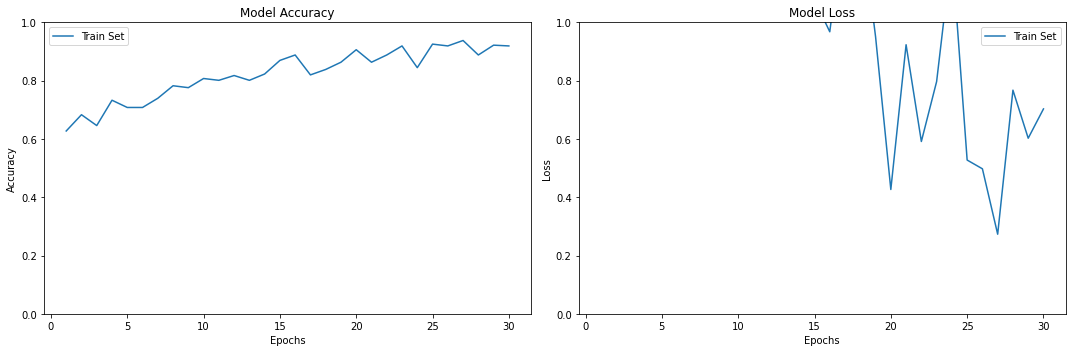

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

# Model Accuracy plot
plt.subplot(1, 2, 1)
plt.ylim(0.,1)
plt.plot(epochs_range, acc, label='Train Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# Model Loss Plot 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.legend(loc="best")
plt.ylim(0,1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

### Predictions on Validation Data

2/2 [==============================] - 2s 2s/step


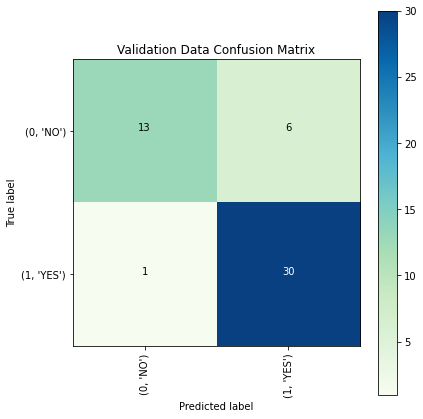

Validation Accuracy = 0.86
Precision: 0.8333333333333334
Recall: 0.967741935483871
F1 Score: 0.8955223880597015


In [ ]:
predictions = model.predict(X_val_preprocess)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)


confusion_mtx = confusion_matrix(y_val, predictions) 
cm = confusion_matrix_plot(confusion_mtx, classes = list(labels.items()), title="Validation Data Confusion Matrix", normalize=False)

print('Validation Accuracy = %.2f' % accuracy)

precision = precision_score(y_val, predictions)
print('Precision:', precision)

recall = recall_score(y_val, predictions)
print('Recall:',recall)

f1 = f1_score(y_val, predictions)
print('F1 Score:',f1)

### Predictions on Test Data

1/1 [==============================] - 1s 1s/step


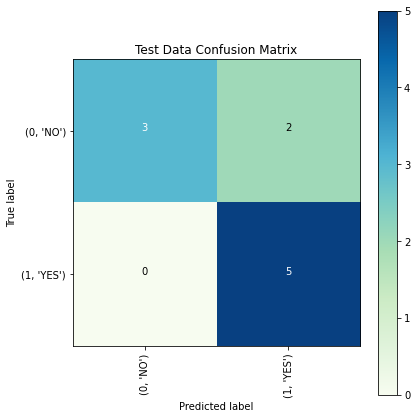

Test Accuracy = 0.80
Precision: 0.7142857142857143
Recall: 1.0
F1 Score: 0.8333333333333333


In [ ]:
predictions = model.predict(X_test_preprocess)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)


confusion_mtx = confusion_matrix(y_test, predictions) 
cm = confusion_matrix_plot(confusion_mtx, classes = list(labels.items()), title="Test Data Confusion Matrix" ,normalize=False)

print('Test Accuracy = %.2f' % accuracy)

precision = precision_score(y_test, predictions)
print('Precision:', precision)

recall = recall_score(y_test, predictions)
print('Recall:',recall)

f1 = f1_score(y_test, predictions)
print('F1 Score:',f1)

In [ ]:
# Save Model
model.save('VGG_model.h5')